# Rydberg Pair Potentials Near Surfaces

In [1]:
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from itertools import product

# Operating system interfaces
import os, sys

# Parallel computing
if sys.platform != "win32": from multiprocessing import Pool

# pairinteraction :-)
if sys.platform == "darwin": sys.path.append("/Applications/pairinteraction.app/Contents/Resources")
elif sys.platform == "win32": sys.path.append("C:\Program Files\pairinteraction")
from libpairinteraction import pireal as pi

# Create cache for matrix elements
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

In [2]:
theta = np.pi/2 # rad
distance_atom = np.linspace(6, 1.5, 100) # µm
distance_surface = 1 # µm

In [3]:
state_one1 = pi.StateOne("Rb", 69, 0, 0.5, 0.5)
state_one2 = pi.StateOne("Rb", 72, 0, 0.5, 0.5)

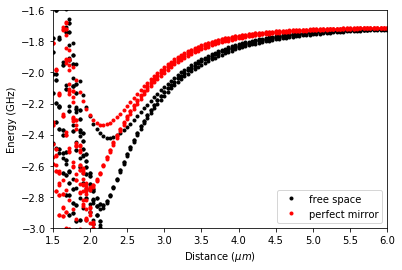

In [4]:
# Set up pair state
state_two = pi.StateTwo(state_one1, state_one2)

# Set up one-atom system
system_one = pi.SystemOne(state_one1.getSpecies(), cache)
system_one.restrictEnergy(min(state_one1.getEnergy(),state_one2.getEnergy()) - 60, \
                          max(state_one1.getEnergy(),state_one2.getEnergy()) + 60)
system_one.restrictN(min(state_one1.getN(),state_one2.getN()) - 3, \
                     max(state_one1.getN(),state_one2.getN()) + 3)
system_one.restrictL(min(state_one1.getL(),state_one2.getL()) - 2, \
                     max(state_one1.getL(),state_one2.getL()) + 2)

# Set up two-atom system
system_two = pi.SystemTwo(system_one, system_one, cache)
system_two.restrictEnergy(state_two.getEnergy() - 6, state_two.getEnergy() + 6)
system_two.setConservedParityUnderPermutation(pi.ODD)
system_two.setConservedParityUnderInversion(pi.ODD)

system_two.setAngle(theta)
system_two.enableGreenTensor(True)
system_two.setDistance(1)
system_two.setSurfaceDistance(1)
system_two.buildInteraction()

# Diagonalize the two-atom system for different surface and interatomic distances
def getDiagonalizedSystems(distances):
    system_two.setSurfaceDistance(distances[0])
    system_two.setDistance(distances[1])
    system_two.diagonalize(1e-3)
    return system_two.getHamiltonian().diagonal()

if sys.platform != "win32":
    with Pool() as pool:
        energies = pool.map(getDiagonalizedSystems, product([1e12, distance_surface], distance_atom))
else:
    energies = list(map(getDiagonalizedSystems, product([1e12, distance_surface], distance_atom)))

energyzero = pi.StateTwo(["Rb", "Rb"], [70, 70], [1, 1], [1.5, 1.5], [1.5, 1.5]).getEnergy()
y = np.array(energies).reshape(2, -1)-energyzero
x = np.repeat(distance_atom, system_two.getNumBasisvectors())

# Plot pair potentials
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"Distance ($\mu m$)")
ax.set_ylabel(r"Energy (GHz)")
ax.set_xlim(np.min(distance_atom),np.max(distance_atom))
ax.set_ylim(-3, -1.6)
ax.plot(x, y[0], 'ko', ms=3, label = 'free space')
ax.plot(x, y[1], 'ro', ms=3, label = 'perfect mirror')
ax.legend();